# Create region mask and timeseries for freshwater IAF simulation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shutil as shutil

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/panan_meltwater/forcing/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37347,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:42981,Total threads: 4
Dashboard: /proxy/35009/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:45037,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

lat_slice  = slice(-90,-59)

In [4]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=13

## Create runoff mask

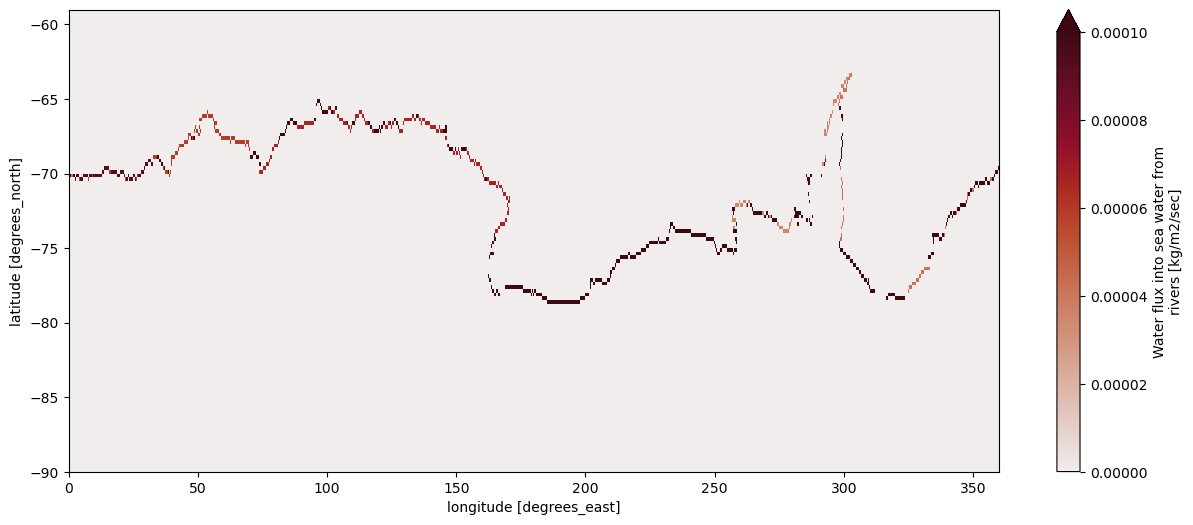

In [5]:
# open FW forcing, so have correct JRA grid:
lat_slice  = slice(-90,-59)

# Note for JRA v1.3 there is only a single runoff file (v1.4 has separate licalvf and friver):
runoff_file = '/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc'
ds = xr.open_dataset(runoff_file,decode_times=False)
# extract arrays from dataset:
runoff = ds.friver
runoff = runoff.isel(time=0).drop('time').sel(latitude=lat_slice)

plt.figure(figsize=(15,6))
runoff.plot(vmin=0,vmax=1e-4,cmap=cmocean.amp)

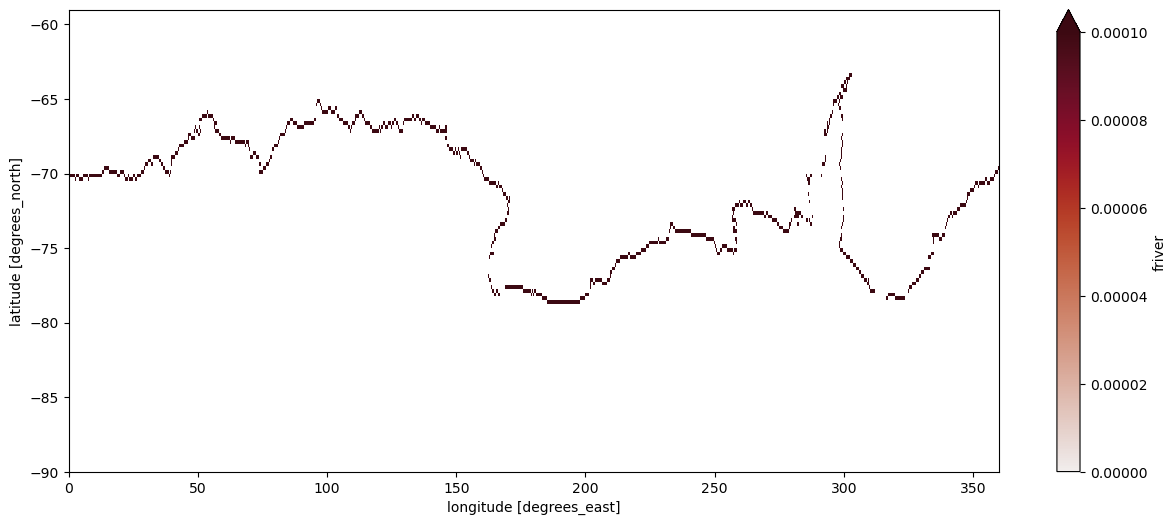

In [6]:
# Note this mask is not quite perfect, there are perhaps a couple of spots missing along the coastline, but I think it's close enough.
runoff_mask = runoff.where(runoff>0)*0+1

plt.figure(figsize=(15,6))
runoff_mask.plot(vmin=0,vmax=1e-4,cmap=cmocean.amp)

## Create runoff anomaly:

In [7]:
# need area on the JRA grid:
# data is 0.25 deg.
resolution=0.25
radius = 6376e3
dy = radius*(np.pi/180*resolution) + runoff.latitude*0
dx = dy*np.cos(runoff.latitude/180*np.pi)
area = dy*dx

# conversion to Gt/yr:
#conversion_factor = 60*60*24*365.25/1e12
# to convert from kg/s to Sv:
conversion_factor = (1e-3)*(1e-6)

# check whole Antarctic runoff, should be close to 2775 Gt/y (Depoorter). Also it matches 0.0876 Sv stated in Tsujino et al. 2018:
Antarctica_runoff = (runoff*area).sum('longitude').sum('latitude')*conversion_factor
# Antarctica_runoff = 0.08759749 Sv

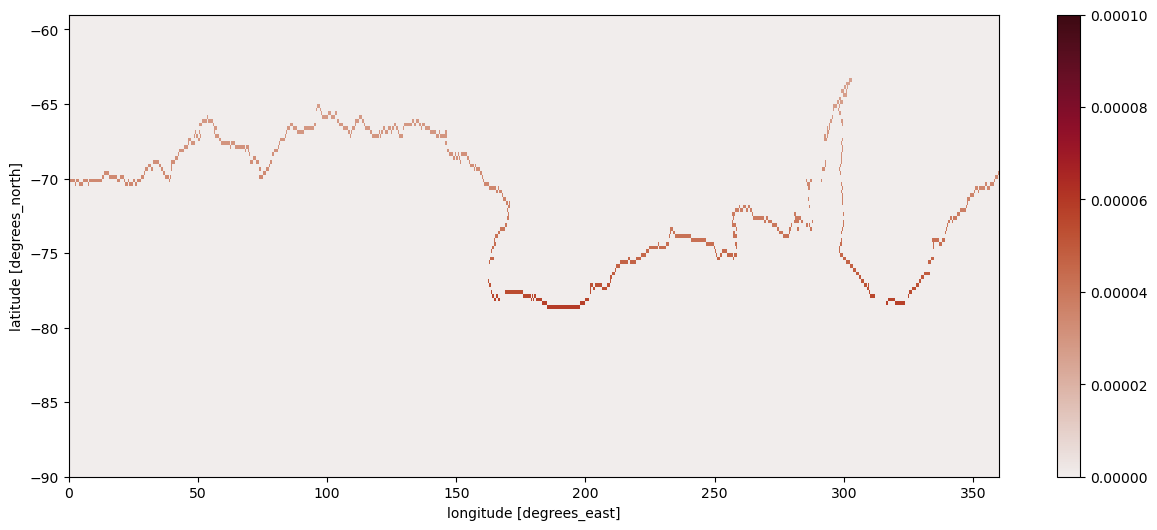

In [8]:
# We want a total anomaly of 0.015 Sv spread all the way around Antarctica.
ssp126_runoff_total = 0.015/conversion_factor

mask_num_points = np.count_nonzero(~np.isnan(runoff_mask))

ssp126_runoff_per_gridcell = ssp126_runoff_total/mask_num_points

ssp126_runoff_anom = runoff_mask + ssp126_runoff_per_gridcell
ssp126_runoff_anom = ssp126_runoff_anom/area
ssp126_runoff_anom = ssp126_runoff_anom.fillna(0)

plt.figure(figsize=(15,6))
ssp126_runoff_anom.plot(vmin=0,vmax=1e-4,cmap=cmocean.amp)

In [9]:
# check sum of runoff anom is what we want it to be:
# check whole Antarctic runoff, should be close to 2775 Gt/y (Depoorter). Also it matches 0.0876 Sv stated in Tsujino et al. 2018:
perturbation_runoff_sum = (ssp126_runoff_anom*area).sum('longitude').sum('latitude')*conversion_factor
# perturbation_runoff_sum = 0.01500167 Sv
perturbation_runoff_sum

<xarray.DataArray ()> Size: 8B
array(0.01500167)

## Save offset file:

In [10]:
# copy old file to write into:
old_file = '/g/data/g40/akm157/model_data/mom6/panan/RYF.runoff_all.1990_1991.nc'
outpath = '/g/data/g40/akm157/model_data/mom6/panan/RYF.runoff_all_SOFIA_ssp126.1990_1991.nc'
shutil.copyfile(old_file,outpath);

# open in writing mode:
ncFile = nc.Dataset(outpath,'r+')

# then add anomaly to old Antarctic values:
ncFile.variables['friver'][:,:len(ssp126_runoff_anom.latitude),:] += ssp126_runoff_anom.values

ncFile.close()

## Check new runoff forcing file looks good:

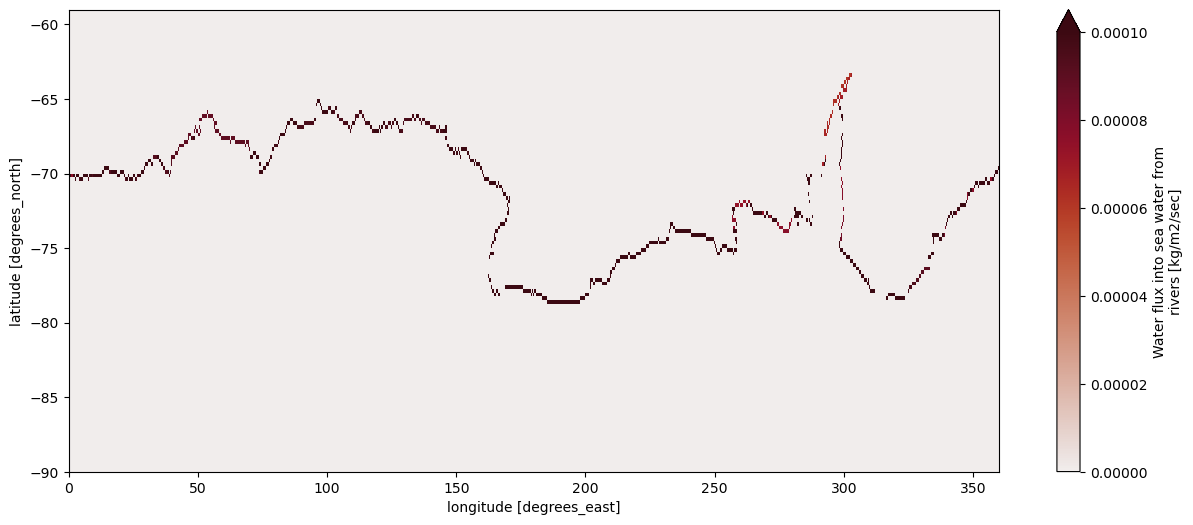

In [11]:
# open FW forcing, so have correct JRA grid:
lat_slice  = slice(-90,-59)

# Note for JRA v1.3 there is only a single runoff file (v1.4 has separate licalvf and friver):
new_runoff_file = '/g/data/g40/akm157/model_data/mom6/panan/RYF.runoff_all_SOFIA_ssp126.1990_1991.nc'
ds = xr.open_dataset(new_runoff_file,decode_times=False)
# extract arrays from dataset:
new_runoff = ds.friver
new_runoff = new_runoff.isel(time=0).drop('time').sel(latitude=lat_slice)

plt.figure(figsize=(15,6))
new_runoff.plot(vmin=0,vmax=1e-4,cmap=cmocean.amp)

In [14]:
# check sum is as expected:

# need area on the JRA grid:
# data is 0.25 deg.
resolution=0.25
radius = 6376e3
dy = radius*(np.pi/180*resolution) + new_runoff.latitude*0
dx = dy*np.cos(new_runoff.latitude/180*np.pi)
area = dy*dx

# conversion to Gt/yr:
#conversion_factor = 60*60*24*365.25/1e12
# to convert from kg/s to Sv:
conversion_factor = (1e-3)*(1e-6)

# check whole Antarctic runoff, should be close to 2775 Gt/y (Depoorter). Also it matches 0.0876 Sv stated in Tsujino et al. 2018:
new_Antarctica_runoff = (new_runoff*area).sum('longitude').sum('latitude')*conversion_factor
# new_Antarctica_runoff = 0.10259916 Sv = 0.08759749 Sv + 0.01500167 Sv

<xarray.DataArray ()> Size: 8B
array(0.01500167)